In [8]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

In [3]:
train_df = pd.read_csv('./archive/fashion-mnist_train.csv', sep=',')
test_df = pd.read_csv('./archive/fashion-mnist_test.csv', sep=',')
train_data = np.array(train_df, dtype = 'float32')
test_data = np.array(test_df, dtype = 'float32')

X_train = train_data[:, 1:] # 학습데이터
y_train = train_data[:, 0] # 학습데이터의 정답 레이블

X_test = test_data[:, 1:] # 테스트데이터
y_test = test_data[:, 0] # 테스트데이터의 정답 레이블

### 정규화

In [4]:
stdscaler = StandardScaler()
X_train_st = stdscaler.fit_transform(X_train)
X_test_st = stdscaler.transform(X_test)

### 차원축소 : PCA

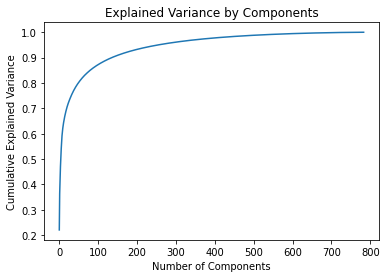

최적 PCA : n_components - 187

In [5]:
pca = PCA(n_components=187, random_state=42)
X_train_pca = pca.fit_transform(X_train_st)
X_test_pca = pca.transform(X_test_st)

### private 로드, 정규화, 차원축소

In [6]:
# private set load
import os
from PIL import Image

data_dir = "./private_data/merged_result_data_shift_half_1/data"
file_names = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
Test_set = []
for file in file_names:
    if file.endswith('png'):
        file_path = os.path.join(data_dir,file)
        img = Image.open(file_path)
        if img.mode == 'RGB':
            img = img.convert('L')
        img_arr = np.array(img,dtype=float)
        img_arr/=255
        # print(img_arr.shape, file)
        Test_set.append(img_arr)

Test_set = np.array(Test_set)
test_flattened = Test_set.reshape(Test_set.shape[0], -1)

test_flattened = stdscaler.transform(test_flattened)
test_pca = pca.transform(test_flattened)

In [7]:
private_pca = test_pca.copy()

In [16]:
private_df = pd.read_csv('./Private_data_csv/Private_data/Private_data.csv', sep=',')
private_data = np.array(private_df, dtype = 'float32')
private_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
private_scale = stdscaler.transform(private_data)
private_pca = pca.transform(private_scale)

데이터 증강...?

---

### 단일 모델 학습
최적 SVM Parameters: `{'C': 10, 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}`

In [7]:
svm_opt = svm.SVC(C=10, degree=3, gamma='scale', kernel='rbf')
svm_opt.fit(X_train_pca, y_train)
svm_opt_y_pred = svm_opt.predict(X_test_pca)
svm_opt_acc = accuracy_score(y_test, svm_opt_y_pred)
print("best SVM 정확도: ", svm_opt_acc)

best SVM 정확도:  0.9063


In [9]:
# 각 test 샘플의 예측 결과를 텍스트 파일에 저장
result_file_path = 'testRsult_SVM_Best_y.txt'
# with open(result_file_path, 'w') as file:
#     for i, pred in enumerate(svm_opt_y_pred):
#         file.write(f'{pred}')

with open(result_file_path, "w") as f:
    for f_name, prediction in zip(file_names, svm_opt_y_pred):
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")

In [10]:
# 각 private 샘플의 예측 결과를 텍스트 파일에 저장
svm_opt_y_pivate = svm_opt.predict(private_pca)
result_file_path = 'testRsult_SVM_Best_private.txt'
# with open(result_file_path, 'w') as file:
#     for i, pred in enumerate(svm_opt_y_pivate):
#         file.write(f'{pred}')

with open(result_file_path, "w") as f:
    for f_name, prediction in zip(file_names, svm_opt_y_pivate):
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")

---

### 앙상블

1. `AdaBoost`

In [13]:
svm_rbf = svm.SVC(C=10, degree=3, gamma='scale', kernel='rbf', probability=True)

ada = AdaBoostClassifier(svm_rbf, n_estimators=10, random_state=42, verbose=True)

ada.fit(X_train_pca, y_train)
y_pred = ada.predict(X_test_pca)
ada_acc = accuracy_score(y_test, y_pred)
print("AdaBoost(최적 SVM 기반) 정확도", ada_acc)

In [ ]:
# 각 test 샘플의 예측 결과를 텍스트 파일에 저장
result_file_path = 'testRsult_Ada_y.txt'
# with open(result_file_path, 'w') as file:
#     for i, pred in enumerate(svm_opt_y_pred):
#         file.write(f'{pred}')

with open(result_file_path, "w") as f:
    for f_name, prediction in zip(file_names, svm_opt_y_pred):
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")

In [ ]:
# 각 private 샘플의 예측 결과를 텍스트 파일에 저장
svm_opt_y_pivate = svm_opt.predict(private_pca)
result_file_path = 'testRsult_Ada_private.txt'
# with open(result_file_path, 'w') as file:
#     for i, pred in enumerate(svm_opt_y_pivate):
#         file.write(f'{pred}')

with open(result_file_path, "w") as f:
    for f_name, prediction in zip(file_names, svm_opt_y_pivate):
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")

2. `Bagging`

In [ ]:
svm_opt = svm.SVC(C=10, degree=3, gamma='scale', kernel='rbf')

bag = BaggingClassifier(svm_opt, 10, random_state=42, verbose=True, n_jobs=2)

bag.fit(X_train_pca, y_train)
y_pred = bag.predict(X_test_pca)
bag_acc = accuracy_score(y_test, y_pred)
print("Bagging(최적 SVM 기반) 정확도", bag_acc)

In [ ]:
y_pred = bag.predict(X_test_pca)
bag_acc = accuracy_score(y_test, y_pred)
print(bag_acc)

In [ ]:
# 각 test 샘플의 예측 결과를 텍스트 파일에 저장
result_file_path = 'testRsult_Bagging_y.txt'
# with open(result_file_path, 'w') as file:
#     for i, pred in enumerate(svm_opt_y_pred):
#         file.write(f'{pred}')

with open(result_file_path, "w") as f:
    for f_name, prediction in zip(file_names, svm_opt_y_pred):
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")

In [ ]:
# 각 private 샘플의 예측 결과를 텍스트 파일에 저장
svm_opt_y_pivate = svm_opt.predict(private_pca)
result_file_path = 'testRsult_Bagging_private.txt'
# with open(result_file_path, 'w') as file:
#     for i, pred in enumerate(svm_opt_y_pivate):
#         file.write(f'{pred}')

with open(result_file_path, "w") as f:
    for f_name, prediction in zip(file_names, svm_opt_y_pivate):
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")

---

### 서로 다른 모델 결합

1. `SVM & linearSVM & 결정트리 => voting`

In [9]:
svm_opt = svm.SVC(C=10, degree=3, gamma='scale', kernel='rbf', random_state=42)
svm_linear = svm.LinearSVC(loss='squared_hinge', C=1, random_state=42)
DT = DecisionTreeClassifier(criterion='entropy', random_state=42)

vote_svm_DT = VotingClassifier(estimators=[('svm_opt', svm_opt), ('svm_linear', svm_linear), ('DT',DT)],
                               voting='hard', n_jobs=4, verbose=True)
vote_svm_DT.fit(X_train_pca, y_train)
vote_svm_DT_y_pred = vote_svm_DT.predict(X_test_pca)
vote_svm_DT_acc = accuracy_score(y_test, vote_svm_DT_y_pred)
print("voting(최적 SVM, linearSVM, 결정트리) 정확도", vote_svm_DT_acc)

voting(최적 SVM, linearSVM, 결정트리) 정확도 0.8799


In [11]:
# 각 test 샘플의 예측 결과를 텍스트 파일에 저장
result_file_path = 'testRsult_Vote_svm_DT_y.txt'
# with open(result_file_path, 'w') as file:
#     for i, pred in enumerate(svm_opt_y_pred):
#         file.write(f'{pred}')

with open(result_file_path, "w") as f:
    for f_name, prediction in zip(file_names, vote_svm_DT_y_pred):
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")

In [19]:
# 각 private 샘플의 예측 결과를 텍스트 파일에 저장
svm_opt_y_pivate = vote_svm_DT.predict(private_pca)
result_file_path = 'testRsult_Vote_svm_DT_private.txt'
# with open(result_file_path, 'w') as file:
#     for i, pred in enumerate(svm_opt_y_pivate):
#         file.write(f'{pred}')

with open(result_file_path, "w") as f:
    for f_name, prediction in zip(file_names, svm_opt_y_pivate):
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")

In [20]:
with open(result_file_path, "w") as f:
    for f_name, prediction in zip(file_names, svm_opt_y_pivate):
        prediction = int(prediction)
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")

In [18]:
private_pca

array([[ 2.3962004e+00, -1.5826545e+00, -2.3741906e+00, ...,
        -4.5112833e-01,  5.7442546e-02,  4.4731724e-01],
       [ 9.7861462e+00, -1.7478561e-01,  8.6935959e+00, ...,
        -1.2751454e-01, -5.9991464e-02, -4.9561419e-02],
       [-2.8269558e+00, -1.2618008e+01, -6.8096757e+00, ...,
        -5.2860194e-01, -5.6782208e-02,  4.9288929e-02],
       ...,
       [ 1.9400639e+01, -6.7537460e+00, -6.8726802e+00, ...,
        -1.4858022e-01,  6.6577971e-01, -4.0637279e-01],
       [ 2.0040323e+01, -2.1320612e+00, -2.3843365e+00, ...,
         1.0799684e-02,  1.7330797e-01,  4.6326548e-02],
       [-1.4528280e+00, -1.2541035e+01, -1.1208300e+01, ...,
         6.1211407e-02, -1.4103121e-01,  4.1051537e-02]], dtype=float32)